In [3]:
!pip install pyngrok


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [33]:
!ngrok config add-authtoken 2660HfRdux # placeholder

Authtoken saved to configuration file: /opt/app-root/src/.config/ngrok/ngrok.yml


In [34]:
from pyngrok import ngrok
ngrok_tunnel = ngrok.connect(8501)
print('Public URL:', ngrok_tunnel.public_url)

Public URL: https://ae86-18-189-75-150.ngrok-free.app


In [31]:
from pyngrok import ngrok
ngrok.kill()

In [32]:
!pkill -f ngrok

In [110]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 106.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Predicted Solubility (ΔGsolv): -3.82 kcal/mol


Solute SMILES,Solvent SMILES,Predicted ΔGsolv (kcal/mol),Solute Image,Solvent Image,Interaction Map
CC(C)(C)Br,COc1ccc(cc1C=O)O,-3.816169023513794,,,

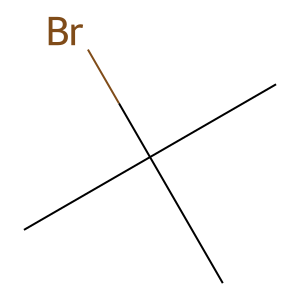
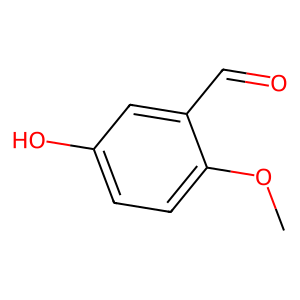
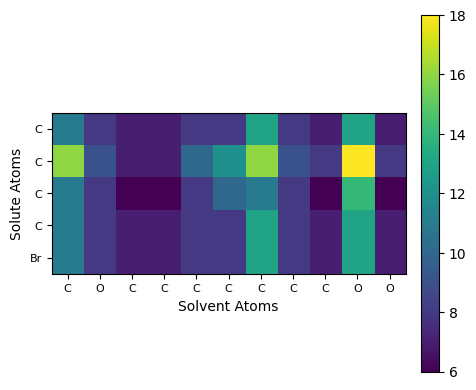

In [131]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import requests
import matplotlib.pyplot as plt
import io
import base64
from IPython.core.display import HTML

# API URL
url = "http://127.0.0.1:3000/predict"

# Input data
solute_smiles = 'CC(C)(C)Br'  # Example solute SMILES
solvent_smiles = 'COc1ccc(cc1C=O)O'  # Example solvent SMILES

# Sending GET request
params = {
    "solute": solute_smiles,
    "solvent": solvent_smiles
}
response = requests.get(url, params=params)

if response.status_code == 200:
    result = response.json()['result']
    delta_g = result['predictions']
    interaction_map = np.array(result['interaction_map'])
    print(f"Predicted Solubility (ΔGsolv): {delta_g:.2f} kcal/mol")
else:
    print("GET Request Failed with status code:", response.status_code)
    exit()

# Helper function to generate base64-encoded molecular images
def smi_to_img_tag(smi: str) -> str:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return ""
    pil_image = Draw.MolToImage(mol)
    with io.BytesIO() as buffer:
        pil_image.save(buffer, format="PNG")
        img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return f'<img src="data:image/png;base64,{img_str}" width="150"/>'

# Helper function to create a heatmap and return as a base64-encoded image
def interaction_map_to_img_tag(interaction_map, solute_atoms, solvent_atoms) -> str:
    fig, ax = plt.subplots(figsize=(5, 5))
    heatmap = ax.imshow(interaction_map, cmap='viridis', interpolation='nearest')

    # Add labels for atoms on x and y axes
    ax.set_xticks(range(len(solvent_atoms)))
    ax.set_yticks(range(len(solute_atoms)))
    ax.set_xticklabels(solvent_atoms, fontsize=8)
    ax.set_yticklabels(solute_atoms, fontsize=8)
    ax.set_xlabel("Solvent Atoms")
    ax.set_ylabel("Solute Atoms")
    plt.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)

    # Save the heatmap as a base64-encoded image
    with io.BytesIO() as buffer:
        plt.savefig(buffer, format="PNG", bbox_inches='tight')
        buffer.seek(0)
        img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    plt.close(fig)
    return f'<img src="data:image/png;base64,{img_str}" width="300"/>'

# Generate atom labels for solute and solvent
solute_mol = Chem.MolFromSmiles(solute_smiles)
solvent_mol = Chem.MolFromSmiles(solvent_smiles)
solute_atoms = [atom.GetSymbol() for atom in solute_mol.GetAtoms()]
solvent_atoms = [atom.GetSymbol() for atom in solvent_mol.GetAtoms()]

# Generate a heatmap image
heatmap_img = interaction_map_to_img_tag(interaction_map, solute_atoms, solvent_atoms)

# Prepare the DataFrame
df = pd.DataFrame({
    "Solute SMILES": [solute_smiles],
    "Solvent SMILES": [solvent_smiles],
    "Predicted ΔGsolv (kcal/mol)": [delta_g],
    "Solute Image": [smi_to_img_tag(solute_smiles)],
    "Solvent Image": [smi_to_img_tag(solvent_smiles)],
    "Interaction Map": [heatmap_img]
})

# Render the DataFrame as an HTML table
def render_html_table(df):
    html = "<table style='border-collapse: collapse; width: 100%;'>"
    html += "<tr style='background-color: lightblue;'>" + "".join([f"<th>{col}</th>" for col in df.columns]) + "</tr>"
    for _, row in df.iterrows():
        html += "<tr>"
        for col in df.columns:
            html += f"<td style='text-align: center;'>{row[col]}</td>"
        html += "</tr>"
    html += "</table>"
    return HTML(html)

# Display the table with heatmap in Jupyter Notebook
render_html_table(df)
